In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import cross_val_score ,cross_val_predict
from math import sqrt
from matplotlib import pyplot as plt
%matplotlib inline  

In [2]:
cnx = sqlite3.connect('C:\MAHA\ACAD\database.sqlite') # Download data from local 
PlayerAttrib = pd.read_sql_query("Select * from Player_Attributes",cnx) 

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 200)


In [4]:
print(PlayerAttrib.head())  # View the Header and Dataframe Structure
print("Dataframe PlayerAttribute Shape")
print(PlayerAttrib.keys()) 
print(PlayerAttrib.shape) 
print("Dataframe PlayerAttribute Size")
print(PlayerAttrib.size)   # View the Size
print("Dataframe PlayerAttribute Columns")
print(PlayerAttrib.columns) # View Columns
print("Dataframe PlayerAttribute Summary")
print(PlayerAttrib.info())  # View Summary

   id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   
3       65.0          right              medium              medium      48.0   
4       65.0          right              medium              medium      48.0   

   finishing  heading_accu

In [5]:
############################################### PREPROCESSING #######################################
########################## ne Hot Encoding the Categorical Variables
preferred_foot_oh = pd.get_dummies(PlayerAttrib['preferred_foot'], prefix='enc')
PlayerAttrib[preferred_foot_oh.columns] = preferred_foot_oh
attacking_work_rate_oh = pd.get_dummies(PlayerAttrib['attacking_work_rate'], prefix='enc')
PlayerAttrib[attacking_work_rate_oh.columns] = attacking_work_rate_oh
defensive_work_rate_oh = pd.get_dummies(PlayerAttrib['defensive_work_rate'], prefix='enc')
PlayerAttrib[defensive_work_rate_oh.columns] = defensive_work_rate_oh


# Creating a new DF for onl Selected Attribtes for Regression
SelPlayerAttrib = PlayerAttrib.drop(['id','player_fifa_api_id','player_api_id','date','preferred_foot',
'attacking_work_rate','defensive_work_rate' ],axis=1)

# Removing rows with Null(NaN r Infinite) Values For the Selected Player Attributes


SelPlayerAttrib = SelPlayerAttrib[(SelPlayerAttrib.overall_rating >= 0) & (SelPlayerAttrib.potential >= 0) & 
(SelPlayerAttrib.crossing >= 0) & (SelPlayerAttrib.finishing >= 0) & (SelPlayerAttrib.heading_accuracy >= 0) &
       (SelPlayerAttrib.short_passing >= 0) & (SelPlayerAttrib.volleys >= 0) & (SelPlayerAttrib.dribbling >= 0) &
       (SelPlayerAttrib.curve >= 0) & (SelPlayerAttrib.free_kick_accuracy >= 0) & (SelPlayerAttrib.long_passing >= 0) &
       (SelPlayerAttrib.ball_control >= 0) & (SelPlayerAttrib.acceleration >= 0) & (SelPlayerAttrib.sprint_speed >= 0) &
       (SelPlayerAttrib.agility >= 0) & (SelPlayerAttrib.reactions >= 0) & (SelPlayerAttrib.balance >= 0) &
       (SelPlayerAttrib.shot_power >= 0) & (SelPlayerAttrib.jumping >= 0) & (SelPlayerAttrib.stamina >= 0) &
       (SelPlayerAttrib.strength >= 0) & (SelPlayerAttrib.long_shots >= 0) & (SelPlayerAttrib.aggression >= 0) &
       (SelPlayerAttrib.interceptions >= 0) & (SelPlayerAttrib.positioning >= 0) & (SelPlayerAttrib.vision >= 0) &
       (SelPlayerAttrib.penalties >= 0) & (SelPlayerAttrib.marking >= 0) & (SelPlayerAttrib.standing_tackle >= 0) &
       (SelPlayerAttrib.sliding_tackle >= 0) & (SelPlayerAttrib.gk_diving >= 0) & (SelPlayerAttrib.gk_handling >= 0) &
       (SelPlayerAttrib.gk_kicking >= 0) & (SelPlayerAttrib.gk_positioning >= 0) & (SelPlayerAttrib.gk_reflexes >= 0)
]



# Creating a New DF to seperate Features , target
Features = SelPlayerAttrib.drop('overall_rating',axis = 1)
Target =   SelPlayerAttrib.overall_rating
print(Features.shape)
print(Target.shape)

########################## Feature Selectin  Using f_regression to find the relation between each feature with the Target 
selector = SelectKBest(f_regression, k=20)
Features_selected = selector.fit_transform(Features, Target)
# Get idxs of columns to keep
col_names = Features.columns.values[selector.get_support()]
fscores = selector.scores_[selector.get_support()]


names_scores = list(zip(col_names, fscores))
featurescores = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
featurescores_sorted = featurescores.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(featurescores_sorted)





(181265, 60)
(181265,)
            Feat_names       F_Scores
11           reactions  265620.757040
0            potential  256841.596329
4        short_passing   48147.760008
10        ball_control   44553.209218
9         long_passing   42253.936223
18              vision   41385.705147
12          shot_power   40614.417989
19           penalties   33053.374124
15          long_shots   33042.005835
17         positioning   28655.433945
5              volleys   27243.594901
7                curve   26607.544728
1             crossing   26587.571580
6            dribbling   26031.558133
8   free_kick_accuracy   25293.084511
2            finishing   22169.286624
13             stamina   21571.466950
16          aggression   21126.006109
14            strength   20167.759516
3     heading_accuracy   19762.333547


(145012, 20)
(36253, 20)
(145012,)
(36253,)
10.7830036196
10.8203580625
0.781324096871
0.780682632029


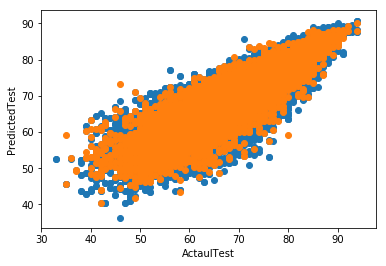

In [7]:
# Split The Training and Test Data in 80% - 20%  corresondingly
Features_train,Features_test,Target_train,Target_test = train_test_split(Features_selected,Target,test_size=0.20)
print(Features_train.shape)
print(Features_test.shape)
print(Target_train.shape)
print(Target_test.shape)


# Build the LR Model
lr = LinearRegression()
lr.fit(Features_train,Target_train)
lr.fit(Features_test,Target_test)

##Predictions       
pred_train = lr.predict(Features_train)
pred_test = lr.predict(Features_test)


# Plot the Training Dataset Model

plt.scatter(Target_train, pred_train)
plt.xlabel("ActaulTrain")
plt.ylabel("PredictedTrain")
plt.show

# Plot the Test Dataset Model

plt.scatter(Target_test, pred_test)
plt.xlabel("ActaulTest")
plt.ylabel("PredictedTest")
plt.show

# Calculate the Mean Squared Error
test_mse = mean_squared_error(pred_test,Target_test)
train_mse = mean_squared_error(pred_train,Target_train)
test_rmse = np.sqrt(test_mse)
train_rmse = np.sqrt(train_mse)

print(test_mse)
print(train_mse)

#Calculate the R2 
training_r2 = lr.score(Features_train,Target_train)
test_r2 = lr.score(Features_test,Target_test)
print(training_r2)
print(test_r2)




Cross-validated scores: [-7.80796345 -7.77286198 -7.90389203 -7.80007558 -7.90669045]
Cross-validated Mean scores: -7.83829669646
Cross-validated predictions: [ 61.3536722   61.3536722   58.98603186 ...,  75.89178003  75.14078887
  73.43112029]
0.841389252611


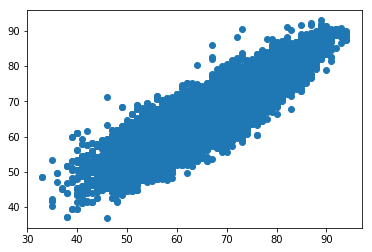

In [10]:
###################################### Using Cross Validation for better scores

X = Features.values
Y = Target.values


scores = cross_val_score(lr, X, Y, cv=5,scoring='neg_mean_squared_error')
print ('Cross-validated scores:', scores)
print ('Cross-validated Mean scores:', scores.mean())

predictions = cross_val_predict(lr, X, Y, cv=5)
plt.scatter(Y, predictions)
print ('Cross-validated predictions:', predictions)

accuracy = r2_score(Y, predictions)
print(accuracy)

